<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Visualization-dataset" data-toc-modified-id="Visualization-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visualization dataset</a></span></li><li><span><a href="#Set-up-experiment-parameters" data-toc-modified-id="Set-up-experiment-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Set up experiment parameters</a></span></li><li><span><a href="#DR-RBF" data-toc-modified-id="DR-RBF-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>DR-RBF</a></span></li><li><span><a href="#DR-Matern" data-toc-modified-id="DR-Matern-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DR-Matern</a></span></li><li><span><a href="#DR-GA" data-toc-modified-id="DR-GA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>DR-GA</a></span></li><li><span><a href="#KES" data-toc-modified-id="KES-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>KES</a></span></li><li><span><a href="#SES" data-toc-modified-id="SES-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>SES</a></span><ul class="toc-item"><li><span><a href="#DeepSets" data-toc-modified-id="DeepSets-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>DeepSets</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Lead-lag-transform" data-toc-modified-id="Lead-lag-transform-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Lead-lag transform</a></span></li></ul></div>

In [1]:
import sys
sys.path.append('../src')

import time
import numpy as np
import torch
import pandas as pd
import importlib
from tqdm import tqdm as tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import utils_roughvol

import DR_RBF
import DR_GA
import DR_Matern
import KES
import SES
import sklearn_transformers
import deep_sets


import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 4),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import pickle

We assume that prices follow the following fractional OU process

$$dX_t =  -\alpha(X_t - \mu) + \nu dW^H_t$$

where $W^H_t$ is fBM with H<0.5. This RDE has an explicit solution

$$X_t = \nu \int_{-\infty}^t e^{-\alpha(t-s)}dW_s^H + \mu$$

The Rough Fractional Stochastic Volatility (RFSV) model is defined in https://arxiv.org/pdf/1410.3394.pdf as follows

$$\sigma_t = e^{X_t}$$

# Visualization dataset

In [8]:
tot = 15
l = 100

a1 = 0.00001
a2 = 0.001
a3 = 0.1

list_df_prices = []
list_df_vols = []

for a in [a1, a2, a3]:
    
    df = pd.DataFrame(data=[utils_roughvol.fOU_generator(a,length=l) for k in range(tot)], 
                      columns=range(l+1)).T
    list_df_prices.append(df)

    list_df_vols.append(df.apply(lambda x: np.exp(x)))

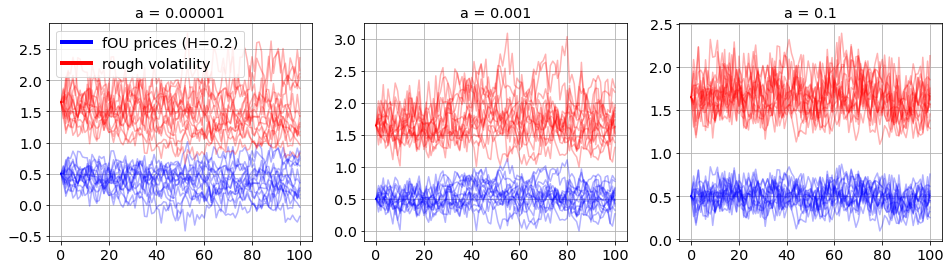

In [9]:
custom_lines = [Line2D([0], [0], color='blue', lw=4), Line2D([0], [0], color='red', lw=4)]

fig, ax = plt.subplots(1, 3)

k=0
for df_p, df_v, a, axx in zip(list_df_prices, list_df_vols, [a1,a2,a3], ax.flatten()):
    if a<1e-4:
        title = 'a = {:.5f}'.format(a)
    else:
        title = 'a = {}'.format(a)
    df_p.plot(grid=True, title=title, legend=False, c='blue', alpha=0.3, ax=axx)
    df_v.plot(grid=True, legend=False, c='red', alpha=0.3, ax=axx)
    if k==0:
        axx.legend(custom_lines, ['fOU prices (H=0.2)', 'rough volatility'])
    k+=1

#plt.savefig('../pictures/fOU_rough_vol.png', bbox_inches='tight')
plt.show()

# Set up experiment parameters

In [2]:
M = 50
N = 20 # change to 20, 50, 100 to reproduce the experiments
length = 200

max_T = 1e0
min_T = 1e-6
np.random.seed(0)
y = np.array((max_T-min_T)*np.random.rand(M)+min_T)

In [3]:
X = []
    
for a in tqdm(y):
    intermediate = []
    for n in range(N):
        path = np.exp(utils_roughvol.fOU_generator(a, length=length)).reshape(-1,1)
        intermediate.append(path)
    X.append(intermediate)

100%|██████████| 50/50 [00:03<00:00, 14.05it/s]


# DR-RBF

In [4]:
m_mse, std_mse, results_RBF = DR_RBF.model(X,y,ll=[0],at=True,mode='krr',NUM_TRIALS=5,  cv=3) 

100%|██████████| 5/5 [00:57<00:00, 11.45s/it]


# DR-Matern

In [5]:
m_mse, std_mse, results_Matern = DR_Matern.model(X,y,at=True,mode='krr',NUM_TRIALS=5,  cv=3) 

100%|██████████| 5/5 [00:47<00:00,  9.51s/it]


# DR-GA

In [6]:
m_mse, std_mse, results_GA = DR_GA.model(X,y,at=True,mode='krr',NUM_TRIALS=5,ll=[0], cv=3,lambdas=[0.01])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1275 out of 1275 | elapsed:  1.6min finished


best lambda (cv on the train set):  0.01
best lambda (cv on the train set):  0.01
best lambda (cv on the train set):  0.01
best lambda (cv on the train set):  0.01
best lambda (cv on the train set):  0.01


# KES

In [7]:
m_mse, std_mse, results_KES = KES.model(X, y,  ll=[0], at=True, scales=[0.35], mode='krr', NUM_TRIALS=5,  cv=3)

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 1275 out of 1275 | elapsed:   37.9s finished
 40%|████      | 2/5 [00:02<00:05,  2.00s/it]

best scaling parameter (cv on the train set):  0.35
best scaling parameter (cv on the train set):  0.35


 80%|████████  | 4/5 [00:03<00:01,  1.07s/it]

best scaling parameter (cv on the train set):  0.35
best scaling parameter (cv on the train set):  0.35


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

best scaling parameter (cv on the train set):  0.35


# SES

In [8]:
m_mse, std_mse, results_SES = SES.model(X, y, depths1=[2,3,4], depth2=2, ll=[0], at=True, NUM_TRIALS=5, cv=3)

 20%|██        | 1/5 [00:05<00:22,  5.68s/it]

best truncation level (cv on train set):  3


 40%|████      | 2/5 [00:11<00:17,  5.68s/it]

best truncation level (cv on train set):  3


 60%|██████    | 3/5 [00:17<00:11,  5.76s/it]

best truncation level (cv on train set):  2


 80%|████████  | 4/5 [00:22<00:05,  5.71s/it]

best truncation level (cv on train set):  3


100%|██████████| 5/5 [00:28<00:00,  5.71s/it]

best truncation level (cv on train set):  3


## DeepSets

In [24]:
batch_size = 100
nb_epoch = 500
importlib.reload(deep_sets)
data = X.copy()

ll = None
at = True

from sklearn_transformers import AddTime, LeadLag
if ll is not None:
    data = LeadLag(ll).fit_transform(data)
if at:
    data = AddTime().fit_transform(data)

In [7]:
MSEs = []
results_deepsets = []

start = time.time()
for j in range(5):
    
    X_train, X_test, y_train, y_test = train_test_split([[x.reshape(-1) for x in xx] for xx in data], y, test_size=0.2, random_state=j)
    np.random.seed(0)
    
    # augment data
    X_train_aug = X_train
    y_train_aug = y_train
    X_train_aug = []
    y_train_aug = []
    for k,bag in enumerate(X_train):
        for i in range(10):
            X_train_aug.append(np.array(bag)+np.random.rand())
            y_train_aug.append(y_train[k]+1e-7*np.random.rand())

    
    train = deep_sets.DataIterator(torch.Tensor(X_train_aug), torch.Tensor(y_train_aug), batch_size, shuffle=True)
    test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = deep_sets.DeepSet
    
    t = deep_sets.Trainer(train.d, model, nb_epoch)
    t.fit(train,test)
    
    res = t.evaluate(test)
    MSEs.append(res)
    
    res_full = t.evaluate(test,return_all=True)
    results_deepsets.append(res_full)


end = time.time()

print('time', end-start)
print(np.mean(MSEs), np.std(MSEs))

# Results

In [9]:
from utils import mape as mape
from utils import mse as mse

In [13]:
print('DR-RBF', mape(results_RBF))
print('DR-Matern', mape(results_Matern))
print('DR-GA',mape(results_GA))
print('KES',mape(results_KES))
print('SES',mape(results_SES))
print('DeepSets',mape(results_deepsets))

In [12]:
print('DR-RBF', mse(results_RBF))
print('DR-Matern', mse(results_Matern))
print('DR-GA',mse(results_GA))
print('KES',mse(results_KES))
print('SES',mse(results_SES))
print('DeepSets',mse(results_deepsets))

**Save results**

In [14]:
results = {'rbf':results_RBF, 'Matern':results_Matern, 'GA':results_GA, 'KER':results_KES, 'SES':results_SES}
pickle.dump(results,open('finance_100_length200.obj','wb'))

# Lead-lag transform

In [39]:
X = np.array([1,5,3,6])[:,None]
a = LeadLag([0]).fit_transform([[X]])

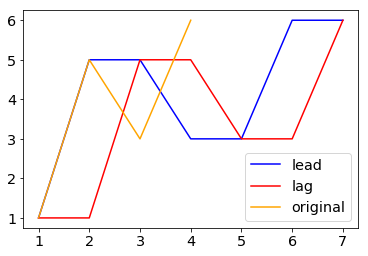

In [41]:
plt.plot(np.arange(1,8),a[0][0][:,0],color='blue',label='lead')
plt.plot(np.arange(1,8),a[0][0][:,1],color='red',label='lag')
plt.plot(np.arange(1,5),X[:,0],color='orange',label='original')
plt.legend()
plt.show()